# LAB 1a:  Exploring natality dataset.

**Learning Objectives**

1. Use BigQuery to explore natality dataset
1. Use Cloud AI Platform Notebooks to plot data explorations


## Introduction 
In this notebook, we will explore the natality dataset before we begin model development and training to predict the weight of a baby before it is born.  We will use BigQuery to explore the data and use Cloud AI Platform Notebooks to plot data explorations.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/1a_explore_data_babyweight.ipynb).

## Load necessary libraries

Check that the Google BigQuery library is installed and if not, install it. 

In [1]:
%%bash
sudo pip3 freeze | grep google-cloud-bigquery==1.6.1 || \
sudo pip3 install google-cloud-bigquery==1.6.1

In [2]:
from google.cloud import bigquery

## The source dataset

Our dataset is hosted in [BigQuery](https://cloud.google.com/bigquery/). The CDC's Natality data has details on US births from 1969 to 2008 and is a publically available dataset, meaning anyone with a GCP account has access. Click [here](https://console.cloud.google.com/bigquery?project=bigquery-public-data&p=publicdata&d=samples&t=natality&page=table) to access the dataset.

The natality dataset is relatively large at almost 138 million rows and 31 columns, but simple to understand. `weight_pounds` is the target, the continuous value we’ll train a model to predict.

<h2> Explore data </h2>

The data is natality data (record of births in the US). The goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that -- this way, twins born on the same day won't end up in different cuts of the data. We'll first create a SQL query using the natality data after the year 2000.

In [3]:
query = """
SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks,
    FARM_FINGERPRINT(
        CONCAT(
            CAST(YEAR AS STRING),
            CAST(month AS STRING)
        )
    ) AS hashmonth
FROM
    publicdata.samples.natality
WHERE
    year > 2000
"""

Let's create a BigQuery client that we can use throughout the notebook.

In [4]:
bq = bigquery.Client()

Let's now examine the result of a BiqQuery call in a Pandas DataFrame using our newly created client.

In [5]:
# Call BigQuery and examine in dataframe
df = bigquery.Client().query(query + " LIMIT 100").to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,6.686620,True,18,1,43,8904940584331855459
1,9.360828,True,32,1,41,1088037545023002395
2,8.437091,False,30,1,39,5896567601480310696
3,6.124442,False,24,1,40,-6244544205302024223
4,7.125340,False,26,1,41,-8029892925374153452


First, let's get the set of all valid column names in the natality dataset. We can do this by accessing the `INFORMATION_SCHEMA` for the table from the dataset.

In [6]:
# Query to get all column names within table schema
sql = """
SELECT
    column_name
FROM
    publicdata.samples.INFORMATION_SCHEMA.COLUMNS
WHERE
    table_name = "natality"
"""

# Send query through BigQuery client and store output to a dataframe
valid_columns_df = bq.query(sql).to_dataframe()

# Convert column names in dataframe to a set
valid_columns_set = valid_columns_df["column_name"].tolist()

We can print our valid columns set to see all of the possible columns we have available in the dataset. Of course, you could also find this information by going to the `Schema` tab when selecting the table in the [BigQuery UI](https://console.cloud.google.com/bigquery?project=bigquery-public-data&p=publicdata&d=samples&t=natality&page=table).

In [7]:
print(valid_columns_set)

['source_year', 'year', 'month', 'day', 'wday', 'state', 'is_male', 'child_race', 'weight_pounds', 'plurality', 'apgar_1min', 'apgar_5min', 'mother_residence_state', 'mother_race', 'mother_age', 'gestation_weeks', 'lmp', 'mother_married', 'mother_birth_state', 'cigarette_use', 'cigarettes_per_day', 'alcohol_use', 'drinks_per_week', 'weight_gain_pounds', 'born_alive_alive', 'born_alive_dead', 'born_dead', 'ever_born', 'father_race', 'father_age', 'record_weight']


## Lab Task #1: Use BigQuery to explore natality dataset.
Using the above code as an example, write a query to find the unique values for each of the columns and the count of those values for babies born after the year 2000.
For example, we want to get these values:
<pre>
is_male	num_babies	avg_wt
False	16245054	7.104715
 True	17026860	7.349797
</pre>
This is important to ensure that we have enough examples of each data value, and to verify our hunch that the parameter has predictive value.

Hint (highlight to see): <p style='color:white'>Use COUNT(), AVG() and GROUP BY. For example:
<pre style='color:white'>
SELECT
  is_male,
  COUNT(1) AS num_babies,
  AVG(weight_pounds) AS avg_wt
FROM
  publicdata.samples.natality
WHERE
  year > 2000
GROUP BY
  is_male
</pre>
</p>

In [8]:
# TODO: Create function that gets distinct value statistics from BigQuery
def get_distinct_values(valid_columns_set, column_name):
    """Gets distinct value statistics of BigQuery data column.

    Args:
        valid_columns_set: set, the set of all possible valid column names in
            table.
        column_name: str, name of column in BigQuery.
    Returns:
        Dataframe of unique values, their counts, and averages.
    """
    assert column_name in valid_columns_set, (
        "{column_name} is not a valid column_name".format(
            column_name=column_name))

    sql = f"""
SELECT
  {column_name},
  COUNT(1) AS num_babies,
  AVG(weight_pounds) AS avg_wt
FROM
  publicdata.samples.natality
WHERE
  year > 2000
GROUP BY
  {column_name}
    """

    df = bq.query(sql).to_dataframe()
    
    return df

In [11]:
get_distinct_values(valid_columns_set, 'gestation_weeks')

,gestation_weeks,num_babies,avg_wt
0,33.0,310675,5.285956
1,41.0,2993797,7.786118
2,47.0,43895,7.496152
3,32.0,208791,4.907616
4,36.0,1524448,6.437536
5,35.0,866817,6.079205
6,44.0,265652,7.590076
7,23.0,24340,1.387928
8,21.0,14682,1.111511
9,20.0,10847,1.001574


## Lab Task #2: Use Cloud AI Platform Notebook to plot explorations.

Which factors seem to play a part in the baby's weight?

<b>Bonus:</b> Draw graphs to illustrate your conclusions

Hint (highlight to see): 
<p style='color:white'># TODO: Reusing the get_distinct_values function you just implemented, create function that plots distinct value statistics from BigQuery

Hint (highlight to see): <p style='color:white'> The simplest way to plot is to use Pandas' built-in plotting capability
<pre style='color:white'>
df = get_distinct_values(valid_columns_set, column_name)
df = df.sort_values(column_name)
df.plot(x=column_name, y="num_babies", kind="bar", figsize=(12, 5))
df.plot(x=column_name, y="avg_wt", kind="bar", figsize=(12, 5))
</pre>

In [12]:
# TODO: Create function that plots distinct value statistics from BigQuery
def plot_distinct_values(valid_columns_set, column_name, logy=False):
    """Plots distinct value statistics of BigQuery data column.

    Args:
        valid_columns_set: set, the set of all possible valid column names in
            table.
        column_name: str, name of column in BigQuery.
        logy: bool, if plotting counts in log scale or not.
    """
    df = get_distinct_values(valid_columns_set, column_name)
    df = df.sort_values(column_name)
    df.plot(x=column_name, y="num_babies", kind="bar", figsize=(12, 5))
    df.plot(x=column_name, y="avg_wt", kind="bar", figsize=(12, 5))

Make a bar plot to see `is_male` with `avg_wt` linearly scaled and `num_babies` logarithmically scaled.

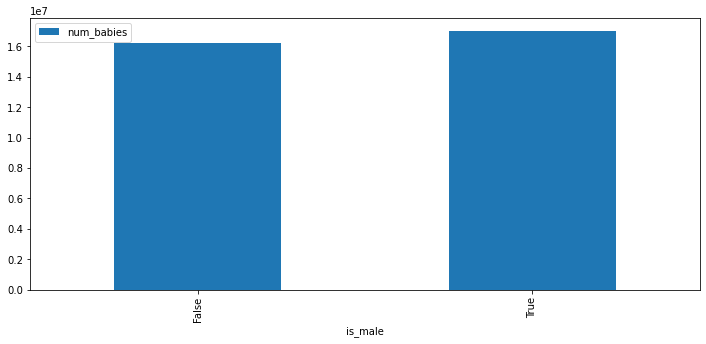

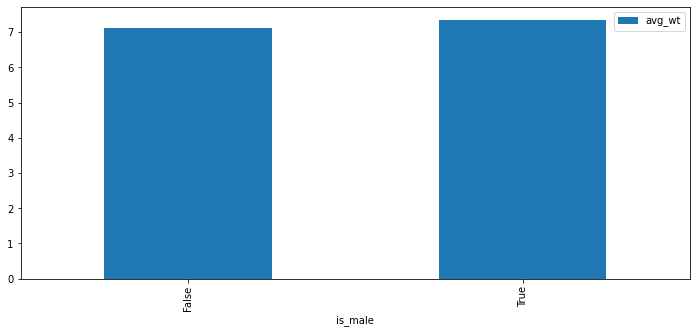

In [13]:
# TODO: Plot is_male
plot_distinct_values(valid_columns_set, 'is_male')

### 우리가 이미 알고 있듯이 출생성별 남자 비율이 약간 높고, 남자 평균 몸무게가 크다는 것을 볼 수 있다.

Make a bar plot to see `mother_age` with `avg_wt` linearly scaled and `num_babies` linearly scaled.

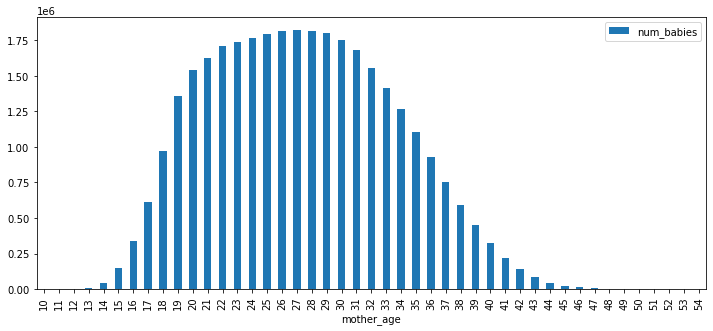

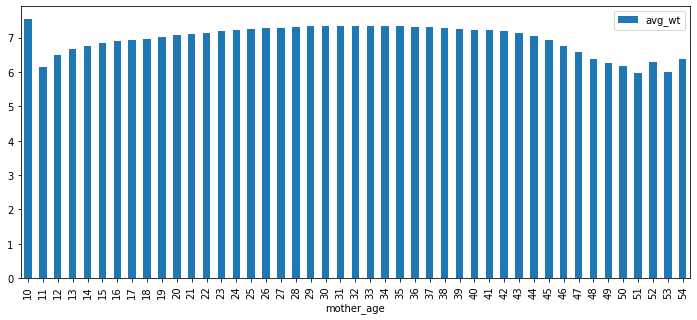

In [14]:
# TODO: Plot mother_age
plot_distinct_values(valid_columns_set, 'mother_age')

### 10~16세인 산모의 데이터가 별로 없고 일반적이지 않으므로 제거하는 것이 타당하다

Make a bar plot to see `plurality` with `avg_wt` linearly scaled and `num_babies` logarithmically scaled.

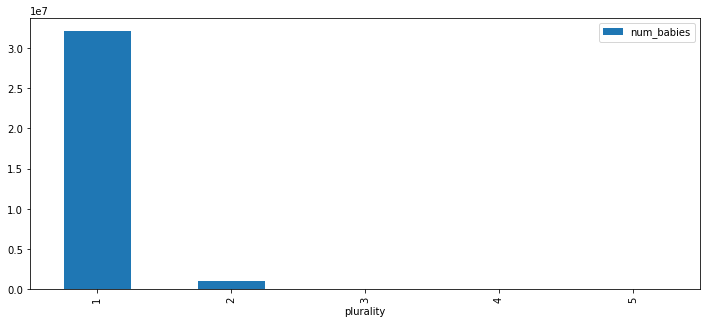

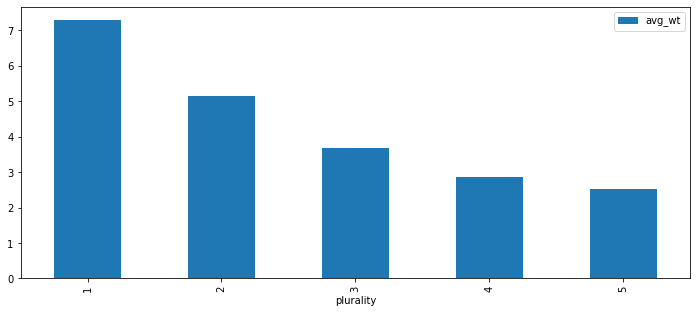

In [15]:
# TODO: Plot plurality
plot_distinct_values(valid_columns_set, 'plurality')

### 쌍둥이 태아가 많을 수록 평균 태아 몸무게가 작음을 알 수 있다.

Make a bar plot to see `gestation_weeks` with `avg_wt` linearly scaled and `num_babies` logarithmically scaled.

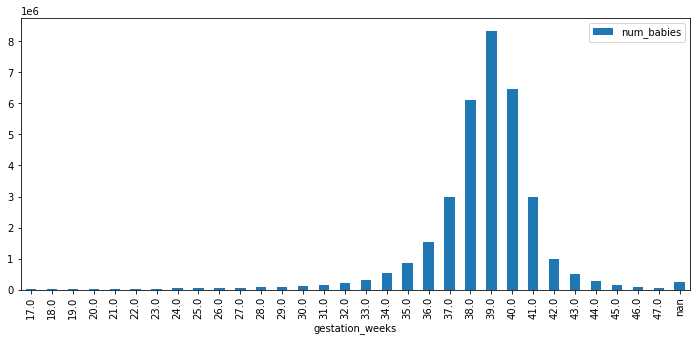

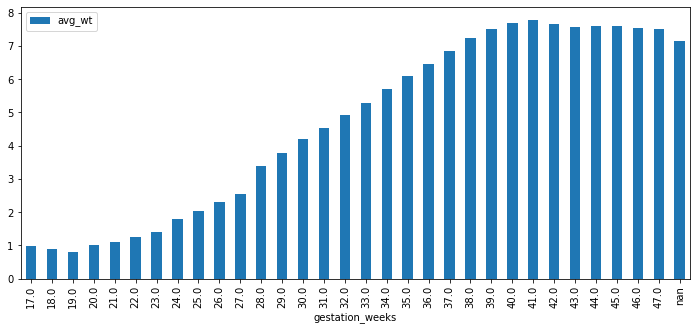

In [16]:
# TODO: Plot gestation_weeks
plot_distinct_values(valid_columns_set, 'gestation_weeks')

All these factors seem to play a part in the baby's weight. Male babies are heavier on average than female babies. Teenaged and older moms tend to have lower-weight babies. Twins, triplets, etc. are lower weight than single births. Preemies weigh in lower as do babies born to single moms. In addition, it is important to check whether you have enough data (number of babies) for each input value. Otherwise, the model prediction against input values that doesn't have enough data may not be reliable.
<p>
In the next notebooks, we will develop a machine learning model to combine all of these factors to come up with a prediction of a baby's weight.

## Lab Summary: 
In this lab, we used BigQuery to explore the data and used Cloud AI Platform Notebooks to plot data explorations.

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License